In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-08-29 14:38:43 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-08-29 14:38:43 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-08-29 14:38:43 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-08-29 14:38:45 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-29 14:38:45 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-29 14:38:46 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-08-29 14:38:46 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-08-29 14:38:46 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-08-29 14:38:46 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-08-29 14:38:46 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-08-29 14:38:47 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-08-29 14:38:47 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-08-29 14:39:35 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-08-29 14:39:35 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-08-29 14:39:35 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [7]:
# file_path = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "selection",
#     # "profession.json"
#     # "nationality.json"
#     "objects.json",
# )

# with open(file_path, "r") as f:
#     temp = json.load(f)

# for cat in temp["categories"]:
#     temp["categories"][cat] = [obj.capitalize() for obj in temp["categories"][cat]]

# with open(file_path, "w") as f:
#     json.dump(temp, f, indent=4)


In [8]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

select_task.filter_single_token(tokenizer=mt.tokenizer, prefix=" ")

print(select_task)

SelectOneTask: (different objects)
Categories: fruit(11), vehicle(8), furniture(8), animal(13), music instrument(3), clothing(11), electronics(11), sport equipment(5), kitchen appliance(4), vegetable(5), building(14), office supply(8), bathroom item(7), flower(6), tree(10), jewelry(7)



In [9]:
sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    obj_idx=2,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)

print(sample)
print(sample.prompt())

Grape -> Banana (2): ['Factory', 'Guitar', 'Banana', 'Helmet', 'Mixer', 'Car']
Options: Factory, Guitar, Banana, Helmet, Mixer, Car.
Which among these objects mentioned above is a fruit?
Answer:


In [10]:
from src.selection.utils import verify_correct_option
# sample.prompt_template = select_prof.prompt_templates[3]
print(f'"{sample.prompt()}"', ">>", sample.obj)

verify_correct_option(
    mt=mt,
    target=sample.obj,
    options=sample.options,
    input=sample.prompt()
)

"Options: Factory, Guitar, Banana, Helmet, Mixer, Car.
Which among these objects mentioned above is a fruit?
Answer:" >> Banana


(True,
 [PredictedToken(token=' Banana', prob=0.67578125, logit=21.375, token_id=76924, metadata=None),
  PredictedToken(token=' The', prob=0.1328125, logit=19.75, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.0712890625, logit=19.125, token_id=362, metadata=None),
  PredictedToken(token=' Among', prob=0.06298828125, logit=19.0, token_id=22395, metadata=None),
  PredictedToken(token=' B', prob=0.01092529296875, logit=17.25, token_id=426, metadata=None)],
 OrderedDict([(76924,
               (1,
                PredictedToken(token=' Banana', prob=0.67578125, logit=21.375, token_id=76924, metadata=None))),
              (17367,
               (56,
                PredictedToken(token=' Factory', prob=9.441375732421875e-05, logit=12.5, token_id=17367, metadata=None))),
              (47759,
               (107,
                PredictedToken(token=' Guitar', prob=2.2411346435546875e-05, logit=11.0625, token_id=47759, metadata=None))),
              (3341,
            

In [11]:
from src.functional import generate_with_patch

gen = generate_with_patch(
    mt = mt,
    inputs = sample.prompt(),
    max_new_tokens=20,
    do_sample=False,
    remove_prefix=True
)[0]
print(f'"{gen}"', ">>", sample.obj)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
You have set `compile_config`, but we are unable to meet the criteria for compilation. Compilation will be skipped.


" Banana.
Explanation: Banana is a type of fruit. The other options are not fruits. Factory is" >> Banana


In [12]:
mt.n_layer, mt.config.num_attention_heads

(80, 64)

In [13]:
llama_70_heads = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]

qwen_72_heads = [
    (62, 1),
    (60, 9),
    (64, 8),
    (62, 0),
    (62, 45),
    (59, 59),
    (71, 28),
    (64, 12),
    (61, 7),
    (64, 13),
    (67, 53),
    (67, 51),
    (54, 44),
    (57, 5),
    (59, 60),
    (71, 25),
    (62, 7),
    (64, 9),
    (62, 23),
    (65, 40),
]

qwen_32_heads = [
    (51, 11),
    (48, 4),
    (52, 21),
    (54, 35),
    (48, 8),
    (50, 6),
    (48, 9),
    (48, 32),
    (52, 10),
    (45, 11),
    (45, 13),
    (48, 34),
    (53, 16),
    (50, 12),
    (49, 2),
    (54, 38),
    (55, 4),
    (50, 27),
    (54, 33),
    (50, 14),
]

# HEADS = [(35, 19)]
# with open("optimized_heads.json", "r") as f:
#     HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:100]
# ]
# HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx < 61]

HEADS = qwen_32_heads
# HEADS = llama_70_heads
print(len(HEADS))

20


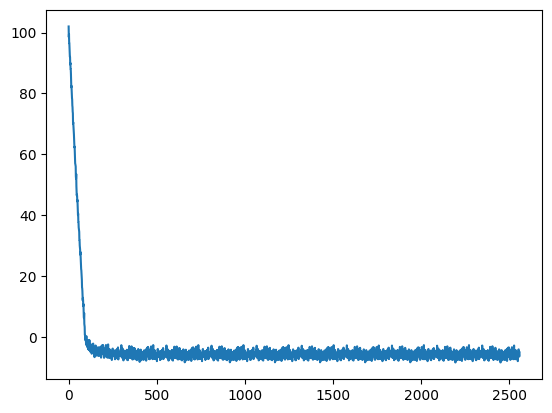

In [32]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_backup_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    mt.name.split("/")[-1],
    "distinct_options",
    f"{select_task.task_name}",
    "epoch_10.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

78


(True, True)

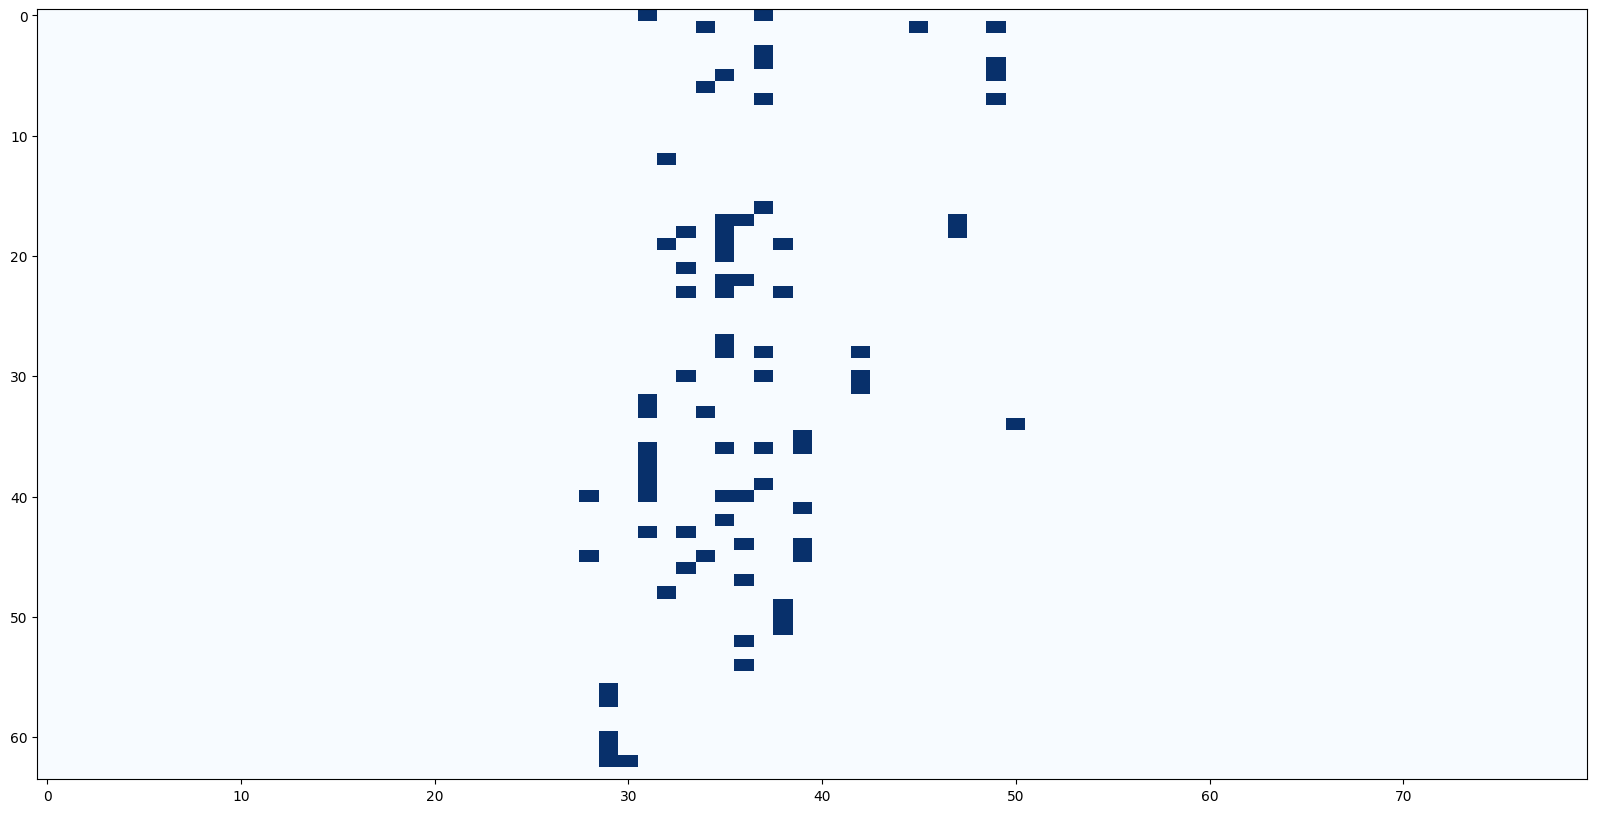

In [33]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[51:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected if layer_idx < 50
]
print(len(heads_selected))

HEADS = heads_selected

(35, 19) in HEADS, (35, 19) in heads_selected

In [26]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    pivot=sample.subj,
    mt=mt,
    heads=HEADS,
)

2025-08-29 14:52:51 src.selection.functional DEBUG    Predictions: ['" Car"[3341] (p=0.668, logit=21.750)', '" The"[578] (p=0.149, logit=20.250)', '" A"[362] (p=0.080, logit=19.625)', '" Among"[22395] (p=0.049, logit=19.125)', '" It"[1102] (p=0.008, logit=17.375)']
2025-08-29 14:52:51 src.selection.functional INFO     Combined attention matrix for all heads


In [73]:
import random
import copy
from src.tokens import prepare_input
from src.selection.utils import KeyedSet


def get_composition_samples(
    task: SelectOneTask,
    mt: ModelandTokenizer,
    unit_categories: list[str],
    prompt_template_idx=3,
    option_style="single_line",
    filter_by_lm_prediction: bool = True,
    n_distractors: int = 5,
):
    unit_samples = []
    for category in unit_categories:
        unit_samples.append(
            task.get_random_sample(
                mt=mt,
                category=category,
                prompt_template_idx=prompt_template_idx,
                option_style=option_style,
                filter_by_lm_prediction=filter_by_lm_prediction,
                n_distractors=n_distractors,
            )
        )

    exclude_objs = [sample.obj for sample in unit_samples]
    clean_category = random.choice(list(set(task.categories) - set(unit_categories)))
    target_category = random.choice(unit_categories)
    target_obj = random.choice(
        (
            KeyedSet(
                items=task.category_wise_examples[target_category],
                tokenizer=mt.tokenizer,
            )
            - KeyedSet(items=exclude_objs, tokenizer=mt.tokenizer)
        ).values
    )
    obj_idx = random.randint(0, n_distractors)
    target_idx = random.choice([i for i in range(n_distractors + 1) if i != obj_idx])

    clean_sample = task.get_random_sample(
        mt=mt,
        category=clean_category,
        obj_idx=obj_idx,
        prompt_template_idx=prompt_template_idx,
        option_style=option_style,
        filter_by_lm_prediction=filter_by_lm_prediction,
        n_distractors=n_distractors,
        exclude_objs=exclude_objs,
        exclude_distractor_categories=unit_categories,
        insert_distractor=[(target_obj, target_idx)],
    )
    comp_sample = copy.deepcopy(clean_sample)
    comp_sample.category = " or ".join(unit_categories)
    comp_sample.obj = target_obj
    comp_sample.obj_idx = target_idx
    assert (
        "<_category_>" in comp_sample.prompt_template
    ), "Composition prompt template must have <_category_> token"
    # comp_sample.prompt_template = comp_sample.prompt_template.replace(
    #     "<_category_>", " or ".join(unit_categories)
    # )

    if filter_by_lm_prediction:
        tokenized = prepare_input(tokenizer=mt, prompts=comp_sample.prompt())
        is_correct, predictions, track_options = verify_correct_option(
            mt=mt,
            target=comp_sample.obj,
            options=comp_sample.options,
            input=tokenized,
        )
        comp_sample.metadata["tokenized"] = tokenized

        logger.debug(comp_sample.prompt())
        logger.debug(
            f"{comp_sample.subj} | {comp_sample.category} -> {comp_sample.obj} | pred={[str(p) for p in predictions]}"
        )
        if not is_correct:
            logger.error(
                f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(predictions[0].token_id)}"] != {comp_sample.ans_token_id}["{mt.tokenizer.decode(comp_sample.ans_token_id)}"]'
            )
            return get_composition_samples(
                task=task,
                mt=mt,
                unit_categories=unit_categories,
                prompt_template_idx=prompt_template_idx,
                option_style=option_style,
                filter_by_lm_prediction=filter_by_lm_prediction,
                n_distractors=n_distractors,
            )
        comp_sample.prediction = predictions

    return unit_samples, clean_sample, comp_sample


unit_samples, clean_sample, comp_sample = get_composition_samples(
    task=select_task,
    mt=mt,
    unit_categories=["fruit", "vehicle"],
    prompt_template_idx=3,
    option_style="single_line",
    filter_by_lm_prediction=True,
    n_distractors=5,
)

2025-08-29 18:04:05 __main__ DEBUG    Options: Elm, Shorts, Hospital, Strawberry, Bat, Chain.
Which among these objects mentioned above is a fruit or vehicle?
Answer:
2025-08-29 18:04:05 __main__ DEBUG    Baseball | fruit or vehicle -> Strawberry | pred=['" Strawberry"[89077] (p=0.586, logit=19.250)', '" Among"[22395] (p=0.080, logit=17.250)', '" The"[578] (p=0.070, logit=17.125)', '" None"[2290] (p=0.048, logit=16.750)', '" There"[2684] (p=0.026, logit=16.125)']


In [126]:
failed_case_idx = 10
failed_case = failed_cases[failed_case_idx]
unit_samples = failed_case["unit_samples"]
clean_sample = failed_case["clean_sample"]
comp_sample = failed_case["comp_sample"]

In [127]:
print(clean_sample.prompt(), ">>", clean_sample.obj)
print(comp_sample.prompt(), ">>", comp_sample.obj)

Options: Mouse, Bamboo, Blender, Ottoman, Paper, Watch.
Which among these objects mentioned above is a office supply?
Answer: >> Paper
Options: Mouse, Bamboo, Blender, Ottoman, Paper, Watch.
Which among these objects mentioned above is a tree or clothing?
Answer: >> Bamboo


In [128]:
from src.functional import generate_with_patch
mt.reset_forward()
mt.set_attn_implementation("eager")

for sample in unit_samples:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        heads=HEADS,
        # heads=[(35, 19)],
        # generate_full_answer=True,
        query_index=-1
    )

for sample in [clean_sample, comp_sample]:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        heads=HEADS,
        # heads=[(35, 19)],
        # generate_full_answer=True,
        query_index=-1
    )

Options: Apple, Oak, Gloves, Notebook, Keyboard, Lily.
Which among these objects mentioned above is a tree?
Answer: >> Oak
2025-08-29 18:45:00 src.selection.functional DEBUG    Predictions: ['" Oak"[18787] (p=0.688, logit=21.375)', '" The"[578] (p=0.093, logit=19.375)', '" Among"[22395] (p=0.093, logit=19.375)', '" An"[1556] (p=0.034, logit=18.375)', '" Apple"[8325] (p=0.030, logit=18.250)']
2025-08-29 18:45:00 src.selection.functional INFO     Combined attention matrix for all heads


Options: Bear, Oven, Shorts, School, Rose, Bat.
Which among these objects mentioned above is a clothing?
Answer: >> Shorts
2025-08-29 18:45:00 src.selection.functional DEBUG    Predictions: ['" Shorts"[91782] (p=0.734, logit=20.500)', '" The"[578] (p=0.087, logit=18.375)', '" Among"[22395] (p=0.060, logit=18.000)', '" shorts"[36876] (p=0.022, logit=17.000)', '" Short"[10928] (p=0.012, logit=16.375)']
2025-08-29 18:45:00 src.selection.functional INFO     Combined attention matrix for all heads


Options: Mouse, Bamboo, Blender, Ottoman, Paper, Watch.
Which among these objects mentioned above is a office supply?
Answer: >> Paper
2025-08-29 18:45:01 src.selection.functional DEBUG    Predictions: ['" Paper"[18343] (p=0.695, logit=20.125)', '" Mouse"[18191] (p=0.107, logit=18.250)', '" The"[578] (p=0.051, logit=17.500)', '" Among"[22395] (p=0.027, logit=16.875)', '" Pen"[13597] (p=0.021, logit=16.625)']
2025-08-29 18:45:01 src.selection.functional INFO     Combined attention matrix for all heads


Options: Mouse, Bamboo, Blender, Ottoman, Paper, Watch.
Which among these objects mentioned above is a tree or clothing?
Answer: >> Bamboo
2025-08-29 18:45:01 src.selection.functional DEBUG    Predictions: ['" Bamboo"[98028] (p=0.539, logit=19.125)', '" None"[2290] (p=0.121, logit=17.625)', '" Ottoman"[70110] (p=0.083, logit=17.250)', '" The"[578] (p=0.044, logit=16.625)', '" Mouse"[18191] (p=0.031, logit=16.250)']
2025-08-29 18:45:01 src.selection.functional INFO     Combined attention matrix for all heads


In [129]:
from src.selection.functional import cache_q_projections
from src.utils.typing import TokenizerOutput
from src.tokens import prepare_input, find_token_range

query_indices = {-3: -3, -2: -2, -1: -1}
query_locations = [
    (layer_idx, head_idx, patch_query_idx)
    for layer_idx, head_idx in HEADS
    # for layer_idx, head_idx in [(35, 19)]
    for patch_query_idx in query_indices.keys()
]

unit_query_states = []
for sample in unit_samples:
    if "tokenized" in sample.metadata:
        tokenized = TokenizerOutput(data=sample.metadata["tokenized"])
    else:
        tokenized = prepare_input(prompts=sample.prompt(), tokenizer=mt.tokenizer)
    unit_query_states.append(
        cache_q_projections(
            mt=mt,
            input=tokenized,
            query_locations=query_locations,
        )
    )

In [130]:
from src.functional import PatchSpec
combined_q_proj_patches = []

for layer_idx, head_idx, query_idx in unit_query_states[0]:
    proj = torch.stack([
        query_state[(layer_idx, head_idx, query_idx)] for query_state in unit_query_states
    ]).squeeze().sum(dim=0)
    combined_q_proj_patches.append(
        PatchSpec(
            location=(
                mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                head_idx,
                query_idx,
            ),
            patch=proj,
        )
    )

comp_attn = verify_head_patterns(
    prompt=clean_sample.prompt(),
    mt=mt,
    heads=HEADS,
    # heads=[(35, 19)],
    # generate_full_answer=True,
    query_index=-1,
    query_patches=combined_q_proj_patches,
)

2025-08-29 18:45:15 src.selection.functional DEBUG    Predictions: ['" Mouse"[18191] (p=0.871, logit=20.500)', '" The"[578] (p=0.038, logit=17.375)', '" Bamboo"[98028] (p=0.012, logit=16.250)', '" Among"[22395] (p=0.009, logit=15.875)', '" A"[362] (p=0.008, logit=15.812)']
2025-08-29 18:45:15 src.selection.functional INFO     Combined attention matrix for all heads


In [131]:
failed_case["patched_pred"], failed_case["patched_track"]

([PredictedToken(token=' Mouse', prob=0.87109375, logit=20.5, token_id=18191, metadata=None),
  PredictedToken(token=' The', prob=0.038330078125, logit=17.375, token_id=578, metadata=None),
  PredictedToken(token=' Bamboo', prob=0.01239013671875, logit=16.25, token_id=98028, metadata=None),
  PredictedToken(token=' Among', prob=0.008544921875, logit=15.875, token_id=22395, metadata=None),
  PredictedToken(token=' A', prob=0.00799560546875, logit=15.8125, token_id=362, metadata=None)],
 OrderedDict([(18191,
               (1,
                PredictedToken(token=' Mouse', prob=0.87109375, logit=20.5, token_id=18191, metadata=None))),
              (98028,
               (3,
                PredictedToken(token=' Bamboo', prob=0.01239013671875, logit=16.25, token_id=98028, metadata=None))),
              (18343,
               (51,
                PredictedToken(token=' Paper', prob=0.000213623046875, logit=12.1875, token_id=18343, metadata=None))),
              (88668,
               (

In [132]:
failed_case["clean_pred"], failed_case["clean_track"]

([PredictedToken(token=' Paper', prob=0.6953125, logit=20.125, token_id=18343, metadata=None),
  PredictedToken(token=' Mouse', prob=0.10693359375, logit=18.25, token_id=18191, metadata=None),
  PredictedToken(token=' The', prob=0.050537109375, logit=17.5, token_id=578, metadata=None),
  PredictedToken(token=' Among', prob=0.0269775390625, logit=16.875, token_id=22395, metadata=None),
  PredictedToken(token=' Pen', prob=0.02099609375, logit=16.625, token_id=13597, metadata=None)],
 OrderedDict([(18343,
               (1,
                PredictedToken(token=' Paper', prob=0.6953125, logit=20.125, token_id=18343, metadata=None))),
              (18191,
               (2,
                PredictedToken(token=' Mouse', prob=0.10693359375, logit=18.25, token_id=18191, metadata=None))),
              (98028,
               (9,
                PredictedToken(token=' Bamboo', prob=0.0050048828125, logit=15.1875, token_id=98028, metadata=None))),
              (10573,
               (24,
     

## Scale Up

In [121]:
random.sample(select_task.categories, 2)

['sport equipment', 'jewelry']

In [ ]:
#########################################
LIMIT = 20
#########################################

test_set = []
while len(test_set) < LIMIT:
    unit_samples, clean_sample, comp_sample = get_composition_samples(
        task=select_task,
        mt=mt,
        unit_categories=random.sample(select_task.categories, 2),
        prompt_template_idx=3,
        option_style="single_line",
        filter_by_lm_prediction=True,
        n_distractors=5,
    )
    test_set.append((unit_samples, clean_sample, comp_sample))

2025-08-29 18:43:51 __main__ DEBUG    Options: Motorcycle, Pin, Eagle, Pen, Drum, Willow.
Which among these objects mentioned above is a flower or jewelry?
Answer:
2025-08-29 18:43:51 __main__ DEBUG    Tape | flower or jewelry -> Pin | pred=['" Pin"[17929] (p=0.293, logit=18.250)', '" Willow"[65449] (p=0.139, logit=17.500)', '" None"[2290] (p=0.095, logit=17.125)', '" The"[578] (p=0.095, logit=17.125)', '" Pen"[13597] (p=0.065, logit=16.750)']
2025-08-29 18:43:52 __main__ DEBUG    Options: Cabinet, Mixer, Folder, Elm, Piano, Tie.
Which among these objects mentioned above is a kitchen appliance or electronics?
Answer:
2025-08-29 18:43:52 __main__ DEBUG    Drum | kitchen appliance or electronics -> Mixer | pred=['" Mixer"[72392] (p=0.719, logit=20.250)', '" The"[578] (p=0.086, logit=18.125)', '" A"[362] (p=0.067, logit=17.875)', '" Among"[22395] (p=0.031, logit=17.125)', '" Cabinet"[34046] (p=0.015, logit=16.375)']
2025-08-29 18:43:52 __main__ DEBUG    Options: Pin, Baseball, Paper, Pepp

In [123]:
from tqdm.auto import tqdm
from src.functional import patch_with_baukit, interpret_logits
from src.selection.utils import get_first_token_id

query_indices = {-3: -3, -2: -2, -1: -1}
query_locations = [
    (layer_idx, head_idx, patch_query_idx)
    for layer_idx, head_idx in HEADS
    for patch_query_idx in query_indices.keys()
]

test_results = []
for unit_samples, clean_sample, comp_sample in tqdm(test_set):
    clean_obj = get_first_token_id(clean_sample.obj, tokenizer=mt.tokenizer)
    target_obj = get_first_token_id(comp_sample.obj, tokenizer=mt.tokenizer)

    unit_query_states = []
    for sample in unit_samples:
        if "tokenized" in sample.metadata:
            tokenized = TokenizerOutput(data=sample.metadata["tokenized"])
        else:
            tokenized = prepare_input(prompts=sample.prompt(), tokenizer=mt.tokenizer)
        unit_query_states.append(
            cache_q_projections(
                mt=mt,
                input=tokenized,
                query_locations=query_locations,
            )
        )

    inputs = TokenizerOutput(data=clean_sample.metadata["tokenized"])
    interested_tokens = [
        get_first_token_id(option, mt.tokenizer) for option in clean_sample.options
    ]

    # clean_run
    clean_output = patch_with_baukit(
        mt=mt,
        inputs=inputs,
    )
    clean_logits = clean_output.logits[:, -1, :]
    clean_pred, clean_track = interpret_logits(
        tokenizer=mt.tokenizer, logits=clean_logits, interested_tokens=interested_tokens
    )
    before_intervention = {
        "clean_rank": clean_track[clean_obj][0],
        "clean_logit": clean_track[clean_obj][1].logit,
        "target_rank": clean_track[target_obj][0],
        "target_logit": clean_track[target_obj][1].logit,
    }

    # patched run

    combined_q_proj_patches = []

    for layer_idx, head_idx, query_idx in unit_query_states[0]:
        proj = (
            torch.stack(
                [
                    query_state[(layer_idx, head_idx, query_idx)]
                    for query_state in unit_query_states
                ]
            )
            .squeeze()
            .sum(dim=0)
        )
        combined_q_proj_patches.append(
            PatchSpec(
                location=(
                    mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                    head_idx,
                    query_idx,
                ),
                patch=proj,
            )
        )
        
    patched_output = patch_with_baukit(
        mt=mt,
        inputs=inputs,
        patches=combined_q_proj_patches,
    )
    patched_logits = patched_output.logits[:, -1, :]
    patched_pred, patched_track = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=patched_logits,
        interested_tokens=interested_tokens,
    )
    after_intervention = {
        "clean_rank": patched_track[clean_obj][0],
        "clean_logit": patched_track[clean_obj][1].logit,
        "target_rank": patched_track[target_obj][0],
        "target_logit": patched_track[target_obj][1].logit,
    }

    test_results.append(
        {
            "unit_samples": unit_samples,
            "clean_sample": clean_sample,
            "comp_sample": comp_sample,
            "before_intervention": before_intervention,
            "after_intervention": after_intervention,
            "clean_pred": clean_pred,
            "clean_track": clean_track,
            "patched_pred": patched_pred,
            "patched_track": patched_track,
        }
    )

  0%|          | 0/20 [00:00<?, ?it/s]

In [125]:
import numpy as np

clean_rank_delta = []
target_rank_delta = []
for result in test_results:
    clean_rank_delta.append(result["after_intervention"]["clean_rank"] - result["before_intervention"]["clean_rank"])
    target_rank_delta.append(result["after_intervention"]["target_rank"] - result["before_intervention"]["target_rank"])

clean_rank_delta = np.array(clean_rank_delta)
target_rank_delta = np.array(target_rank_delta)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [result["after_intervention"]["clean_rank"] for result in test_results]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [result["after_intervention"]["target_rank"] for result in test_results]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

print("="*100)

clean_logit_delta = []
target_logit_delta = []
for result in test_results:
    clean_logit_delta.append(result["after_intervention"]["clean_logit"] - result["before_intervention"]["clean_logit"])
    target_logit_delta.append(result["after_intervention"]["target_logit"] - result["before_intervention"]["target_logit"])

clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [result["after_intervention"]["clean_logit"] for result in test_results]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    result["after_intervention"]["target_logit"] for result in test_results
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

print("="*100)

counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in test_results:
    clean_sample = intervention_result["clean_sample"]
    comp_sample = intervention_result["comp_sample"]
    int_track = intervention_result["patched_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == get_first_token_id(comp_sample.obj, tokenizer=mt.tokenizer)
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(intervention_result)

top_1_accuracy = counter_patch_type_top_option / len(test_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(test_results)})"
)

clean_rank_delta: 65.6500 ± 111.7123
target_rank_delta: -114.6000 ± 242.6014
clean_rank_after_intervention: 66.6500 ± 111.7123
target_rank_after_intervention: 44.7000 ± 120.2756
clean_logit_delta: -7.4188 ± 3.0543
target_logit_delta: 5.7313 ± 5.2487
clean_logit_after_intervention: 14.0437 ± 2.8724
target_logit_after_intervention: 17.8406 ± 4.0857
Counterfactual patching accuracy: 0.4500 (9/20)
